<font size=7> Latencies Analysis

In [120]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, read_phy_files,\
                                  plot_latency_dist_hist, plot_latency_angle_hist
from human_hip.animate import animate_latencies

In [121]:
with open("/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/sd_ca1_curated.pkl", "rb") as filename:
    sd = pickle.load(filename)

In [122]:
import numpy as np
from human_hip.spike_data import latencies, cross_sttc
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt

In [124]:
#https://medium.com/@dreamferus/how-to-synchronize-time-series-using-cross-correlation-in-python-4c1fd5668c7a#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6ImM3ZTExNDEwNTlhMTliMjE4MjA5YmM1YWY3YTgxYTcyMGUzOWI1MDAiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMDI5NDUwNDY4Mjk4NDg1MzY1NjYiLCJoZCI6InVjc2MuZWR1IiwiZW1haWwiOiJtZWxsaW90MUB1Y3NjLmVkdSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJuYmYiOjE2OTM1MTg3MjksIm5hbWUiOiJNYXR0IEVsbGlvdHQiLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EvQUFjSFR0ZWRoeVRrWk1hU1hJRTFqa1hhZEVmbmhxc3NwNW1lVFkzUHV0THluMVJ1TXc9czk2LWMiLCJnaXZlbl9uYW1lIjoiTWF0dCIsImZhbWlseV9uYW1lIjoiRWxsaW90dCIsImxvY2FsZSI6ImVuIiwiaWF0IjoxNjkzNTE5MDI5LCJleHAiOjE2OTM1MjI2MjksImp0aSI6Ijc5NGMxOTk1NmI5NDJiNWQzNGIzODc0YTdjYzQ1ZTgyZTlkNjdjZTYifQ.mrDH7b9_D0YfYF3xxqJl-Kh5w_XeWgpyntt19-Bvs4VJJpuJR5DRRJsSGO52guE8jSdYsSDS_ILzPyY_rZAyivCZ4mXJv3CftxbNxgxRD_feS8BNI3YPbTh2Oin7tj32Gzm75Nq4k-UnhQxy9d7qVlw29DA6Wns1yTY0B6cb0pPEuKMWfHmlmCUEtDEDX0dE__pUGkBxWwickpa2n-pW-Z71y-hatFAn80JrOPclPZj1Yts9xeV9uPC7ICWTjSVLZB4Nl8mKy6Rxn6pB_ny01ne06iAoYidx2SwRU3j5BVZF1CK-bhVqQ-qOuzIPj17qvkFE9RJT9Zw842YN9f16MA
def cross_correlation_max_shift(x, y):
    correlations = correlate(x, y, mode="full")
    lags = correlation_lags(x.size, y.size, mode="full")
    return lags[np.argmax(correlations)]


def curate_latencies(sd, cross_sttc_min_cutoff=2, cross_sttc_max_cutoff=15, sttc_cutoff = 0.04, latency_cutoff=1, sigma=15, sttc_delta=20 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=20)  #latency= np.median(pair_latencies)
        if abs(np.median(pair_latencies))> latency_cutoff:
            pairs_late.append( pair )  #lags_late.append( latency )
    pairs= pairs_late
    print( len(pairs_late), "pairs above latencency cutoff")

    # Do cross sttc for all pairs
    print("Starting cross_sttc calculation... might take a minute")
    cross_lag  = [] 
    for pair in pairs: 
        x = np.around( sd.train[pair[0]] ).astype(int)
        y= np.around( sd.train[pair[1]] ).astype(int)
        x_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
        y_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
        x_long[ x ] = 1
        y_long[ y ] = 1
        x_smooth = gaussian_filter(x_long, sigma=sigma) # sigma=15
        y_smooth = gaussian_filter(y_long, sigma=sigma) # sigma=15
        
        cross_lag.append( cross_correlation_max_shift( x_smooth, y_smooth ) ) 

    cross_lag = np.array(cross_lag)
    to_keep = np.where((np.abs(cross_lag)< cross_sttc_max_cutoff) & (np.abs(cross_lag)> cross_sttc_min_cutoff) & (cross_lag!=0) )[0]
    print( len(to_keep), "pairs between cross_sttc cutoffs")
    return np.array(pairs)[ to_keep ] 




<font color="brown"> test method

In [125]:
# good_pairs = curate_latencies(sd)
# with open( 'hc328_good_pairs.pkl' , 'wb') as my_file:
#    pickle.dump(good_pairs, my_file)
##load pickled data
with open( 'hc328_good_pairs.pkl' , 'rb') as my_file:
    good_pairs = pickle.load(my_file)
len(good_pairs)


18496 Starting Pairs
567 pairs above sttc cutoff
360 pairs above latencency cutoff
Starting cross_sttc calculation... might take a minute
60 pairs between cross_sttc cutoffs


<font color="red"> We save curated latency pairs because above calculation took over 1 minute

In [10]:
#good_pairs = curate_latencies(sd)
# good_pairs = curate_latencies(sd)
# with open( 'hc328_good_pairs.pkl' , 'wb') as my_file:
#    pickle.dump(good_pairs, my_file)
# load pickled data
# with open( 'hc328_good_pairs.pkl' , 'rb') as my_file:
#     good_pairs = pickle.load(my_file)

18496 Starting Pairs
567 pairs above sttc cutoff
205 pairs above latencency cutoff
Starting cross_sttc calculation... might take a minute
55 pairs between cross_sttc cutoffs


In [7]:
pair=[0,4]

In [12]:
sd.length/1000/60

6.420634166666667

In [76]:
x = np.around( sd.train[0] ).astype(int)
y= np.around( sd.train[4] ).astype(int)
x_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
y_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
x_long[ x ] = 1
y_long[ y ] = 1
x_smooth = gaussian_filter(x_long, sigma=8)
y_smooth = gaussian_filter(y_long, sigma=8)

In [77]:
cross_correlation_max_shift( x_smooth, y_smooth )

-13

In [66]:
# cross_corr = np.correlate(x_smooth, y_smooth, mode='full')

# # Determine the range of valid lags
# lag = np.arange(-len(y_smooth) + 1, len(x_smooth))

# # Extract cross-correlation values for shifts between -1000 and 1000
# min_shift = -1000
# max_shift = 1000

# # Ensure the shifts are within the valid range of lags
# start_idx = np.where(lag == min_shift)[0][0]
# end_idx = np.where(lag == max_shift)[0][0]

# cross_corr_values = cross_corr[start_idx:end_idx+1]


In [51]:
# check smoothin works
# x = np.around( sd.train[0] ).astype(int)
# y= np.around( sd.train[4] ).astype(int)
# x_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
# y_long = np.zeros( np.around( sd.length + 1 ).astype(int) )
# x_long[ x ] = 1
# y_long[ y ] = 1
# x_smooth = gaussian_filter(x_long, sigma=8)
# y_smooth = gaussian_filter(y_long, sigma=8)
#plt.plot(  gaussian_filter(x_long, sigma=15)[2380:2450] )

array([  2415,   4601,   4934,   5713,   7828,  10306,  10867,  16161,
        18274,  18342,  19076,  19725,  23172,  23725,  24133,  24265,
        24451,  24854,  25065,  25301,  25552,  25775,  25814,  26197,
        26735,  26953,  27122,  27909,  28838,  29508,  29774,  31046,
        31398,  31535,  32181,  32656,  33346,  33409,  33984,  34225,
        34401,  35218,  35410,  36027,  36127,  36860,  37319,  37552,
        39020,  40904,  41153,  41909,  42291,  42422,  42461,  42511,
        44985,  45570,  45805,  46191,  46520,  46562,  46609,  47178,
        47246,  47740,  47980,  48273,  48570,  48648,  49076,  49377,
        49672,  49804,  51578,  53416,  53948,  54781,  55868,  56230,
        56625,  57112,  57496,  58508,  59279,  59622,  60154,  60744,
        61130,  61191,  61764,  61845,  62055,  62378,  62579,  63017,
        63144,  63415,  63460,  63795,  64034,  64554,  65145,  65319,
        65722,  66676,  66884,  67154,  67378,  67550,  67866,  68099,
      

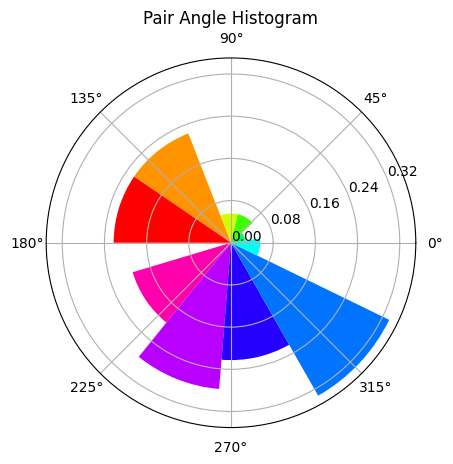

In [126]:
plot_latency_angle_hist(sd, good_pairs)

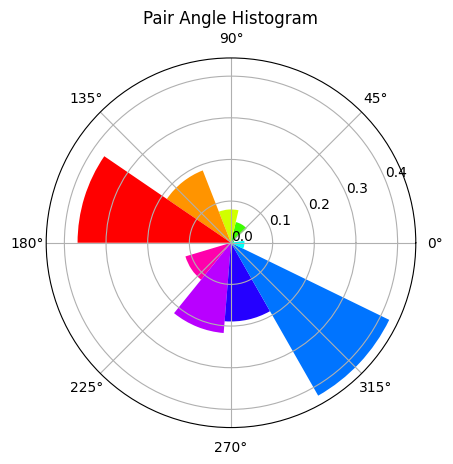

In [127]:
plot_latency_angle_hist(sd, good_pairs, by_firing_rate=True)

# Vector plots

In [128]:
plot_vector_layout

<function human_hip.spike_data.plot_latencies.plot_vector_layout(sd, pairs, normalize=True, plot_neuron=True, arrow_length=75, min_dist=0, image_path=None, xlim=None, ylim=None, background_color='white')>

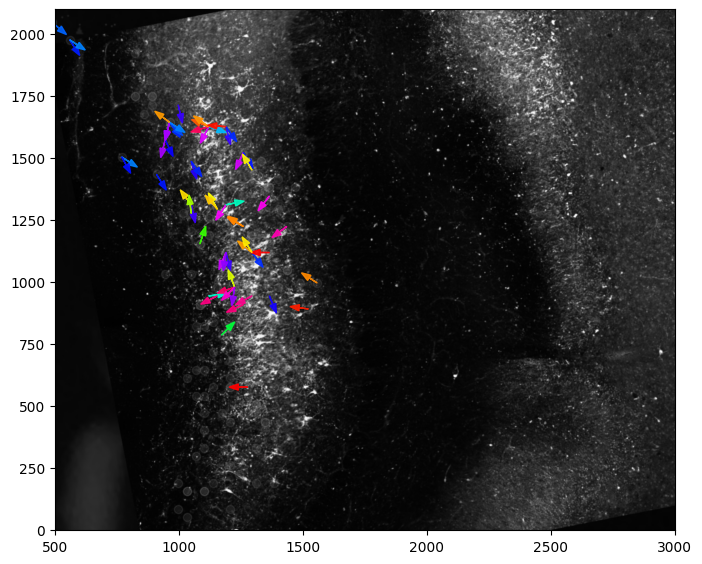

In [129]:
plot_vector_layout( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc328_bw.jpeg", xlim=(500,3000) )

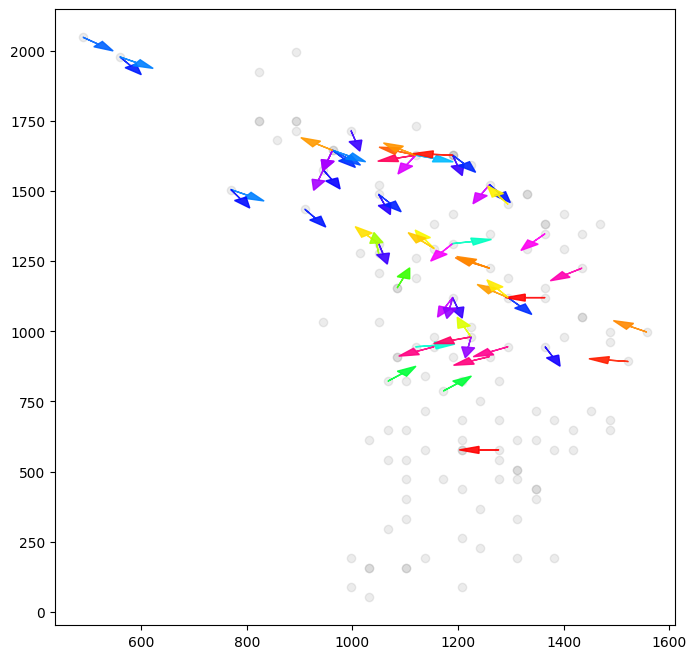

In [130]:
plot_vector_layout( sd, good_pairs)